In [26]:
# Import necessary modules
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from tensorflow.python.framework.test_ops import n_ints_out

In [14]:
# Load CSV data into a pandas DataFrame
df = pd.read_csv('data/Battery_RUL_cleaned.csv')
#df = pd.read_csv('data/Battery_RUL.csv')
df = df[df.columns[1:]]  # Remove the first column

# Last column is the target variable
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def plot_grid_search_results(results, param1, param2, score1, score2):
    """
    Plots the grid search results with two y-axes for different hyperparameter values.

    Parameters:
    - results: DataFrame containing the GridSearchCV results.
    - param1: The first hyperparameter to plot on the x-axis.
    - param2: The second hyperparameter to differentiate the lines.
    - score1: The first score to plot on the primary y-axis.
    - score2: The second score to plot on the secondary y-axis.
    """
    # Create a single plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the first score on the primary y-axis
    for value in results[param2].unique():
        subset = results[results[param2] == value]
        ax1.plot(subset[param1], -subset[score1], label=f'{score1} - {param2}: {value}', linestyle='-', marker='o')
    ax1.set_xlabel(param1)
    ax1.set_ylabel(score1)
    ax1.set_xscale('log')
    ax1.legend(loc='upper left')
    ax1.set_title('Grid Search Results')

    # Create a secondary y-axis for the second score
    ax2 = ax1.twinx()
    for value in results[param2].unique():
        subset = results[results[param2] == value]
        ax2.plot(subset[param1], -subset[score2], label=f'{score2} - {param2}: {value}', linestyle='--', marker='x')
    ax2.set_ylabel(score2)
    ax2.legend(loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


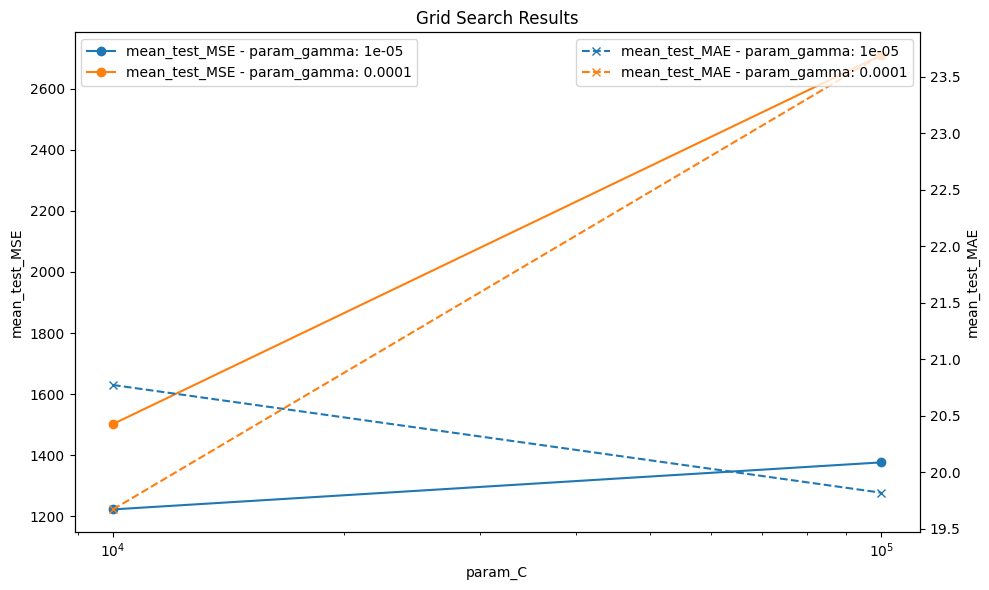

SVR(C=10000.0, gamma=1e-05)
Mean Absolute Error: 20.6758
Mean Squared Error: 1168.4600


In [4]:
# Define the hyperparameter grid
param_grid = [
    {'C': [1e+4, 1e+5], 'kernel': ['rbf'], 'gamma': [1e-5, 1e-4]}]
# Define the scoring dictionary
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False)}
# Initialize and train the SVM model
#model = SVR(kernel='linear', C=0.0001)
# Mean Absolute Error: 35.6885
# Mean Squared Error: 2358.7762
model = GridSearchCV(SVR(), param_grid, cv=5, scoring=scoring, refit='MSE', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)

# Extract the results and convert to a DataFrame
results = pd.DataFrame(model.cv_results_)
results.to_csv('data/SVR2.csv', index=False)

plot_grid_search_results(results, 'param_C', 'param_gamma', 'mean_test_MSE', 'mean_test_MAE')

# Get the best model
best_model = model.best_estimator_
print(best_model)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
# first run: 39.9814

In [15]:
# Define the hyperparameter grid
#param_grid = [
#    {'max_depth': [None, 1, 2, 3, 4, 5, 6], 'n_estimators': [1000] }]
# Define the scoring dictionary
#scoring = {
#    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
#    'MSE': make_scorer(mean_squared_error, greater_is_better=False)}
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=1000,  n_jobs=-1)
#Mean Absolute Error: 7.9780
#Mean Squared Error: 236.9407
#model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring=scoring, refit='MSE', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)

# Extract the results and convert to a DataFrame
#results = pd.DataFrame(model.cv_results_)
#results.to_csv('data/RFR1.csv', index=False)

# Plot the grid search results
#plot_grid_search_results(results, 'param_max_depth', 'param_n_estimators', 'mean_test_MSE', 'mean_test_MAE')

# Get the best model
#best_model = model.best_estimator_
#print(best_model)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
# first run: 8.0703
# best run: 7.9780

Mean Absolute Error: 7.9351
Mean Squared Error: 233.6358


In [10]:
# Define the hyperparameter grid
#param_grid = [
#    {'n_estimators': [1000, 10000, 100000, 1000000], 'learning_rate':[0.1], 'objective': ['reg:squarederror']}]
# Define the scoring dictionary
#scoring = {
#    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
#    'MSE': make_scorer(mean_squared_error, greater_is_better=False)}
# Initialize and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.1, n_jobs=-1)
#Mean Absolute Error: 7.9632
#Mean Squared Error: 210.3707
#model = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=5, scoring=scoring, refit='MSE', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)

# Extract the results and convert to a DataFrame
#results = pd.DataFrame(model.cv_results_)
#results.to_csv('data/XGB2.csv', index=False)

# Plot the grid search results
#plot_grid_search_results(results, 'param_n_estimators', 'param_learning_rate','mean_test_MSE', 'mean_test_MAE')

# Get the best model
#best_model = model.best_estimator_
#print(best_model)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
# first run: 15.3975
# best run: 7.9632

Mean Absolute Error: 7.9632
Mean Squared Error: 210.3707


In [4]:
# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# first run: 39.9814

Mean Absolute Error: 47.2215
Mean Squared Error: 3565.5578


In [24]:
# Initialize and train the CatBoost Regressor
model = cb.CatBoostRegressor(iterations=100000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=0)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
# best run:
# Mean Absolute Error: 7.5714
# Mean Squared Error: 186.3288

Mean Absolute Error: 7.5714
Mean Squared Error: 186.3288


In [27]:
# Initialize and train the Gaussian Process Regressor
model = GaussianProcessRegressor()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


Mean Absolute Error: 567.5223
Mean Squared Error: 419274.5008


In [14]:
# Function to save real and predicted values to a CSV file
def save_predictions_to_csv(model, X_test, y_test, filename):
    y_pred = model.predict(X_test)
    results_df = pd.DataFrame({'Real': y_test, 'data/Predicted': y_pred})
    results_df.to_csv(filename, index=False)

# Support Vector Regressor
model_svr = SVR(kernel='linear', C=0.0001)
model_svr.fit(X_train, y_train)
save_predictions_to_csv(model_svr, X_test, y_test, 'data/svr_predictions.csv')

# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
model_rf.fit(X_train, y_train)
save_predictions_to_csv(model_rf, X_test, y_test, 'data/rf_predictions.csv')

# XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.1, n_jobs=-1)
model_xgb.fit(X_train, y_train)
save_predictions_to_csv(model_xgb, X_test, y_test, 'data/xgb_predictions.csv')

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000, n_jobs=-1)
model_lr.fit(X_train, y_train)
save_predictions_to_csv(model_lr, X_test, y_test, 'data/lr_predictions.csv')

# CatBoost Regressor
model_cb = cb.CatBoostRegressor(iterations=100000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=0)
model_cb.fit(X_train, y_train)
save_predictions_to_csv(model_cb, X_test, y_test, 'data/cb_predictions.csv')